Example of data analysis in python.
Nikhil Bhandari

**Task A**: Load the data directly from the link we provided and view a few rows of each. As a note, if you're reading in the courtsdata using pd.read_csv in Python, you may need to use the following syntax to read from the url:

courts_df = pd.read_csv(courts_data_url, names = ['stop_id', 'ticket_amount', 
                                                  'ticket_status'], skiprows = 1)

*Note*: for all questions, please write your code in the blank R or Python file we provide above.

This is what we will review and score. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# statsmodel library for regressions.
import statsmodels.api as sm
import statsmodels.formula.api as smf

# ignore warnings.
import warnings
warnings.filterwarnings("ignore")

# actual links to the dataset hidden for the github version.
crime_df = pd.read_csv(r'https://.................crime.csv')
stops_df = pd.read_csv(r'https://.................stops.csv')

#crime_df = pd.read_csv(r'C:\Temp\dclab\crime.csv')
#stops_df = pd.read_csv(r'C:\Temp\dclab\stops.csv')

# print crime_df.info()
# print stops_df.info()

print '\nShow a few rows of the data set: Crime Data\n'
print crime_df.head()

print '\nShow a few rows of the data set: Stops Data\n'
print stops_df.head()


Show a few rows of the data set: Crime Data

           X          Y       CCN                REPORT_DAT     SHIFT  METHOD  \
0 -77.058663  38.906846   7093973  2017-06-03T12:54:27.000Z       DAY  OTHERS   
1 -77.018036  38.960747   9251904  2017-04-07T00:00:00.000Z  MIDNIGHT  OTHERS   
2 -76.984955  38.915147  14060710  2017-03-13T00:00:00.000Z  MIDNIGHT  OTHERS   
3 -77.009722  38.824388  16217337  2017-04-03T00:00:00.000Z  MIDNIGHT  OTHERS   
4 -77.017203  38.904526  17037020  2017-03-05T20:46:01.000Z   EVENING  OTHERS   

        OFFENSE                                   BLOCK  XBLOCK  YBLOCK  ...  \
0  THEFT F/AUTO        2900 - 2999 BLOCK OF N STREET NW  394912  137666  ...   
1      HOMICIDE     5800  - 5899 BLOCK OF 4TH STREET NW  398437  143648  ...   
2      HOMICIDE  2000 - 2099 BLOCK OF FENWICK STREET NE  401305  138586  ...   
3      HOMICIDE     2 - 153 BLOCK OF GALVESTON PLACE SW  399156  128511  ...   
4  THEFT F/AUTO   400 - 471 BLOCK OF NEW YORK AVENUE NW  398508  13

**Task B**: Crime incidents are reported down to the hour/minute, while stops are only reported down to the day.

Please create a new column based on `REPORT_DAT` column of the crime incidents data that rounds the exact timestamp for the crime down to the day-- for instance, "2017-06-03T12:54:27.000Z" would become "2017-06-03". Call this column `report_daily`

In [2]:
# note that the downloaded data set already contains a variable
# reports_daily for the crime data.  Using a different name.
crime_df['report_daily_new'] = pd.to_datetime(crime_df['REPORT_DAT'].str[0:10],format='%Y/%m/%d')
stops_df['report_daily_new'] = pd.to_datetime(stops_df['stop_date'],format='%Y/%m/%d')

**Task C**: Create a new data set `crimes_by_day` that gives the total count of crime incidents per day. For the purposes of aggregating, you can consider each unique `OBJECTID' as reflecting a different crime.

Similarly, create a new data set `stops_by_day` that gives the total count of traffic stops per day. For the purposes of aggregating, you can consider each unique `stop_id` as reflecting a different stop.

In [3]:
crimes_grouped = crime_df.groupby('report_daily_new')
crimes_by_day = crimes_grouped['OBJECTID'].count().reset_index()

stops_grouped = stops_df.groupby('report_daily_new')
stops_by_day = stops_grouped['stop_id'].count().reset_index()

# rename columns
crimes_by_day.columns = ['report_date','crime_freq']
stops_by_day.columns = ['stop_date','stop_freq']

**Task D**: For either the traffic stops by day or crime incidents by day, check if there are days missing in the period measured. If so, fill them with the mean across all other days for that data.


In [4]:
print stops_df.head()
# print min(stops_df['report_daily_new']), max(stops_df['report_daily_new'])

# create a range of the dates
idx = pd.date_range(min(stops_df['report_daily_new']), max(stops_df['report_daily_new']))

# check if any data exists for each of the dates. If none exist, add a new row with the mean across all days.
av_stops_by_day = np.mean(stops_by_day['stop_freq'])
print '\nAvg stops by day: %.2f\n'%av_stops_by_day

for x1 in idx:
    if len(stops_by_day[stops_by_day['stop_date'] == x1]) >= 1:
        pass
    else:
        temp = pd.DataFrame([[x1.strftime('%Y-%m-%d'),av_stops_by_day]],columns=['stop_date','stop_freq'])
        temp['stop_date'] = pd.to_datetime(temp['stop_date']) 
        stops_by_day = stops_by_day.append(temp)

print '\nDays that were filled in with avg values.\n'
print stops_by_day[stops_by_day['stop_freq']==av_stops_by_day]


   stop_id officer_id   stop_date  driver_age driver_sex  ticket  \
0    61001          A  2017-03-19          28          f    True   
1    96921          B  2017-08-02          16          m    True   
2   190446          E  2017-05-18          69          m   False   
3   199132          D  2017-05-26          20          f    True   
4     2120          E  2017-06-26          32          m    True   

  report_daily_new  
0       2017-03-19  
1       2017-08-02  
2       2017-05-18  
3       2017-05-26  
4       2017-06-26  

Avg stops by day: 465.21


Days that were filled in with avg values.

   stop_date   stop_freq
0 2017-03-30  465.206897
0 2017-03-31  465.206897
0 2017-04-30  465.206897
0 2017-05-30  465.206897
0 2017-05-31  465.206897
0 2017-06-30  465.206897
0 2017-07-30  465.206897
0 2017-07-31  465.206897


1. **Question**: merge the traffic stops by day data with the crimes by day data. Which specific date has the most traffic stops? Which specific date has the most crime incidents?

Optional bonus: using a coding-based solution, what day of the week was that date?

In [5]:
# merge the data sets.
crimes_stops = pd.merge(left=crimes_by_day, right=stops_by_day, how='inner', left_on='report_date',right_on='stop_date')

# print crimes_stops.head()

print '\nDates with most traffic stops.\n'
print crimes_stops[crimes_stops['stop_freq'] == crimes_stops['stop_freq'].max()][['stop_date','stop_freq']]

print '\nDates with most crime incidents.\n'
print crimes_stops[crimes_stops['crime_freq'] == crimes_stops['crime_freq'].max()][['report_date','crime_freq']]

print '\nDay of the week. -- Crime Data \n'

# crime data
temp = crimes_stops[crimes_stops['crime_freq'] == crimes_stops['crime_freq'].max()][['report_date','crime_freq']]
for index, row in temp.iterrows(): 
    print '%s %s'%(row['report_date'], row['report_date'].strftime('%A'))

print '\nDay of the week. -- Stop Data \n'

# stop data
temp = crimes_stops[crimes_stops['stop_freq'] == crimes_stops['stop_freq'].max()][['stop_date','stop_freq']]
for index, row in temp.iterrows(): 
    print '%s %s'%(row['stop_date'], row['stop_date'].strftime('%A'))



Dates with most traffic stops.

    stop_date  stop_freq
61 2017-05-01      535.0

Dates with most crime incidents.

   report_date  crime_freq
68  2017-05-08         122
89  2017-05-29         122

Day of the week. -- Crime Data 

2017-05-08 00:00:00 Monday
2017-05-29 00:00:00 Monday

Day of the week. -- Stop Data 

2017-05-01 00:00:00 Monday


2. **Question**: : Create a plot where the x axis is the date and the y axis is the ratio of traffic stops to crime incidents. Make sure the axis labels are informative.

*Note*: make sure your code prints out the plot. You do not need to attach the plot here.

What seasonal patterns do you notice? Explain in 1-2 sentences


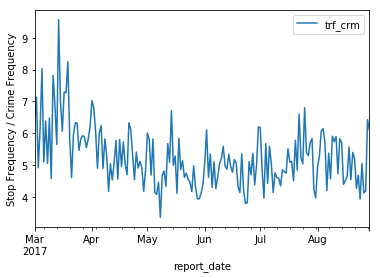

Seasonal patterns: 
        The traffic stop to crime incident is higher during the early 
        spring months and it reduces over the summer.  
        This ratio is maintained during the summer months.
        


In [6]:
# create a ratio variable.
crimes_stops['trf_crm'] = crimes_stops['stop_freq'] / crimes_stops['crime_freq']

crimes_stops.plot(x='report_date', y='trf_crm', kind='line')
plt.ylabel('Stop Frequency / Crime Frequency')
plt.show()

print '''Seasonal patterns: 
        The traffic stop to crime incident is higher during the early 
        spring months and it reduces over the summer.  
        This ratio is maintained during the summer months.
        '''




# Section 2: Policy Evaluation



3\. **Question**: Is there a large difference between the ticket amounts for people with
incomes less than \\$30000 and those with incomes greater than or equal to
\\$30,000? (Tickets are given out in \$0.50 increments).

Explain your answer in 1-2 sentences.

In [7]:
''' Note that the court_data from the web has an error in it.  Some rows have 4 data
    points instead of 3.  I sent an email to dcLab re. this and was advised to
    use what I have.  I am attaching the csv file with the submission.
    
    Basically, I took the csv file and fixed it by assuming that the extra column
    reflected $0.50.
'''

# court_data = pd.read_csv(r'https://surveygizmolibrary.s3.amazonaws.com/library/495376/CourtsData1.csv')
income_data = pd.read_csv(r'https://surveygizmolibrary.s3.amazonaws.com/library/495376/IncomeData.csv')

court_data = pd.read_csv(r'C:\Temp\dclab\CourtsData1_nb.csv')
# income_data = pd.read_csv(r'C:\Temp\dclab\IncomeData.csv')

# print court_data.info()
# print income_data.info()
# print stops_pred_model.info()

print '\nMerge the court data with income data.'
court_income = pd.merge(left=court_data, right=income_data, how='left', left_on='stop_id',right_on='stop_id')

print '\nNumber of records not matched: ', court_income['income'].isnull().sum()

print '\nCreate a variable for income groups.'
court_income['inc_grp'] = np.where(court_income['income']<30000,'Less 30k','More 30k')
court_income['inc_grp'] = np.where(court_income['income'].isnull(),'Unknown',court_income['inc_grp'])
# print court_income.head()

print "\nEstimate the mean of ticket amount: %.2f"%court_income['ticket_amount'].mean()

print '\nCalculate the mean of the ticket amount for incomes less or more than 30k.'
temp = court_income.groupby('inc_grp')
print temp['ticket_amount'].agg([len, np.mean])

print '''
    Response to question.
    There is a $8 difference between incomes less than $30k and 
    incomes more than $30k.  The folks with incomes less than $30k pay $42.4 
    per ticket while folks with incomes more than $30k pay $50.1 per ticket.  
'''



Merge the court data with income data.

Number of records not matched:  6022

Create a variable for income groups.

Estimate the mean of ticket amount: 47.45

Calculate the mean of the ticket amount for incomes less or more than 30k.
              len       mean
inc_grp                     
Less 30k  19128.0  42.424927
More 30k  35107.0  50.155097
Unknown    6022.0  47.600880

    Response to question.
    There is a $8 difference between incomes less than $30k and 
    incomes more than $30k.  The folks with incomes less than $30k pay $42.4 
    per ticket while folks with incomes more than $30k pay $50.1 per ticket.  



4\. **Question**: Use a regression discontinuity design (RDD) to determine whether the new policy has a detectable impact on residents' likelihood of paying on time.

What key (1-3) assumptions did you make?


In [8]:
print '''Key assumptions for RDD:
- Split the data in bins of $5,000.
- For each intervention level, look at bins around the intervention level - 
for the purposes of the model, we will use 75% to 125% of the intervention level.
- We estimate a regression model with a intervention dummy.  If this variable is significant, 
then we can assume that the intervention makes a difference.
'''

Key assumptions for RDD:
- Split the data in bins of $5,000.
- For each intervention level, look at bins around the intervention level - 
for the purposes of the model, we will use 75% to 125% of the intervention level.
- We estimate a regression model with a intervention dummy.  If this variable is significant, 
then we can assume that the intervention makes a difference.



5\. **Question**: A colleague wants you to check the robustness of the results. They're
wondering if we see differences in paying on time at income thresholds other than \$30,000. If
we do, we'd be less sure that the policy is working.

They want to you to plot the distribution of p-values for a test that looks at differences in
paying on time at \\$5,000, \\$10,000 and so on for every \\$5,000 increment up to \\$50,000. They
hope to see null results for incomes other than \\$30,000.

You realize, since that could involves copying and pasting the code for one model many
times, and that it would be more efficient to write a function that:

- Takes in the data and the vector of cutoffs (provided in your code file)

- Re-estimates the model from the previous step

- Returns the p value from that model

Please write a function to that effect, and then use the results to create a plot where the x axis is the income cutoff (again, \\$5,000 to \\$50,000, in \\$5,000 increments) and the y axis is the pvalue for the model estimating the effect of that cutoff on paying on time.

In 1-2 sentences, explain whether the plot strengthens your claims about the effect of the
policy.


Limit data to .75 to 1.25 of the intervention point of 5000


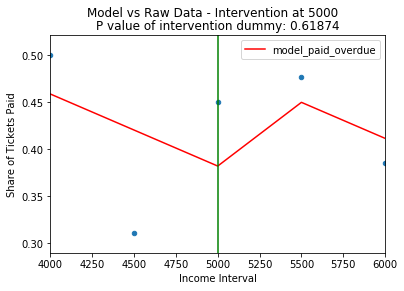

Limit data to .75 to 1.25 of the intervention point of 10000


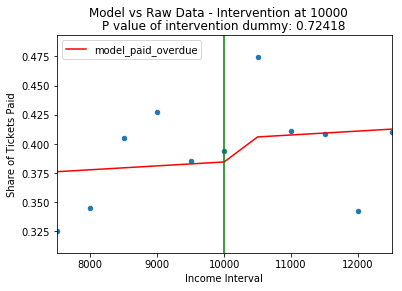

Limit data to .75 to 1.25 of the intervention point of 15000


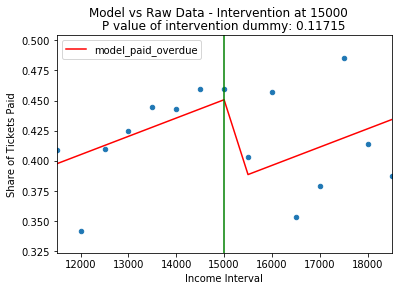

Limit data to .75 to 1.25 of the intervention point of 20000


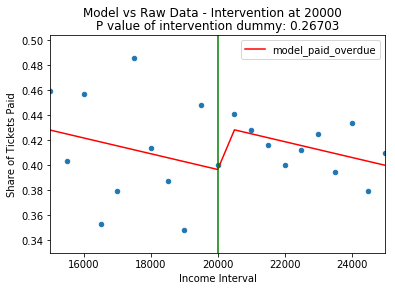

Limit data to .75 to 1.25 of the intervention point of 25000


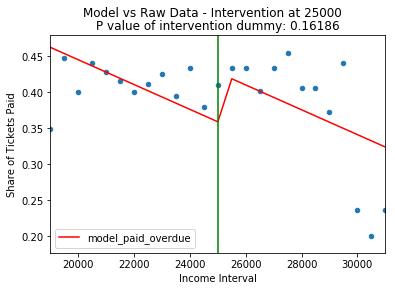

Limit data to .75 to 1.25 of the intervention point of 30000


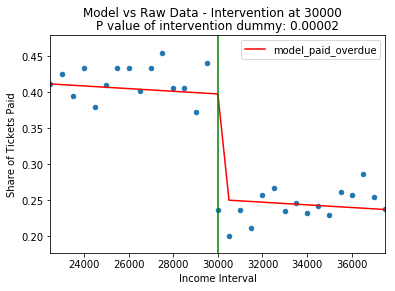

Limit data to .75 to 1.25 of the intervention point of 35000


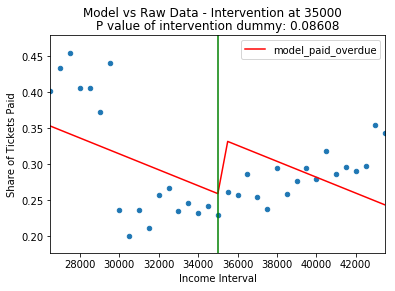

Limit data to .75 to 1.25 of the intervention point of 40000


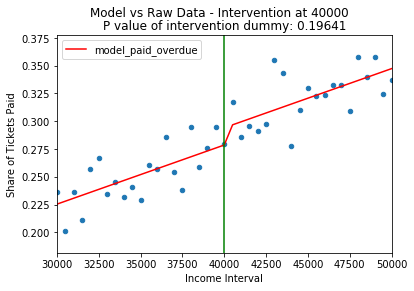

Limit data to .75 to 1.25 of the intervention point of 45000


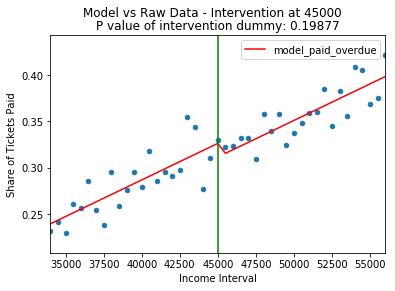

Limit data to .75 to 1.25 of the intervention point of 50000


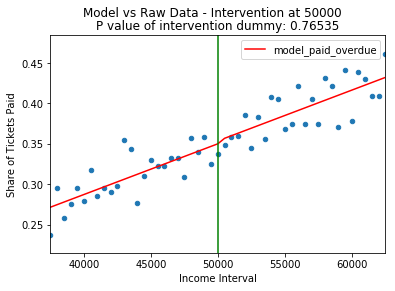

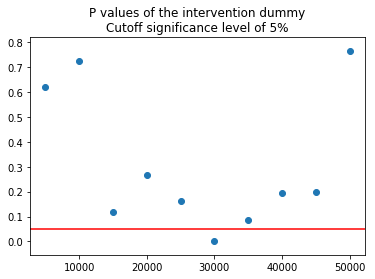


The plot shows that the intervention at $30,000 has a significant effect on the 
likelihood to pay on time - I am not sure about the directionality though 
(see the response to the next question).  Intervention at other income levels does 
not have a significant effect.


In [9]:
import numpy as np
thresholds = list(np.arange(5000, 55000, 5000))

# create a function to estimate a OLS model
# to determine if the intervention is effective or not.
# The intervention variable is a dummy variable and if the 
# estimated coefficient is significant at 5%, then we will consider
# the policy to be effective.

def intervention_paid_overdue(court_income_df, intervention=30000.):
 
    # only consider tickets that have been paid or are overdue
    court_income_df = court_income_df[(court_income_df['ticket_status']=='paid') | (court_income_df['ticket_status']=='overdue')]
    
    # create a 0/1 variable for ticket status.
    court_income_df['ticket_status_01'] =  np.where(court_income_df['ticket_status']=='paid',1,0)
    
    # print court_income_df.head()
    
    # find the min max of incomes.
    min_inc = court_income_df['income'].min()
    max_inc = court_income_df['income'].max()

    # focus on intervention at 30k.
    # intervention = 30000.0

    # create a series with an increment of 500.
    incre_ment = 500.0
    ser_grp = round(max_inc/incre_ment,0)+1 

    # create a data frame for the rdd model
    # start with empty df.
    # add the avg. amount paid for each increment.
    rdd_df = pd.DataFrame(columns=['interval','paid_overdue'])
    for x1 in xrange(0, int(incre_ment*ser_grp), int(incre_ment)):
        temp =  { 'interval': x1, 
                 'paid_overdue': court_income_df[ (court_income_df['income']>=x1) & (court_income_df['income'] < (x1 + incre_ment)) ]['ticket_status_01'].mean() }
        rdd_df = rdd_df.append(temp,ignore_index=True)

    # print 'New data frame created for RDD analysis.  Some rows: '
    # print rdd_df.head()

    # Do a plot of the income and avg fine.
    # rdd_df.plot(x='interval',y='paid_overdue',kind='scatter')
    # plt.title('All data in the RDD data frame')
    # plt.axvline(x=intervention, color='r')
    # plt.show()

    # focus the plot area around the intervention point.
    print 'Limit data to .75 to 1.25 of the intervention point of %d'%intervention
    rdd_interven = rdd_df[(rdd_df['interval']>=intervention*.75) & 
                            (rdd_df['interval'] <=intervention*1.25)]
    
    # rdd_interven.plot(x='interval',y='paid_overdue',kind='scatter')
    # plt.title('Data limited to 75% to 125% of the intervention income')
    # plt.axvline(x=intervention, color='r')
    # plt.show()
    # plt.close()

    # create a dummy variable that indicates the intervention line.
    rdd_interven['intervention_dummy'] = np.where(rdd_interven['interval']<=intervention,1,0)

    # run a regression model.
    reg_model = smf.ols('paid_overdue ~ intervention_dummy + interval', data=rdd_interven).fit()
    # print reg_model.summary()

    # plot the model against the raw data.
    ax = rdd_interven.plot(x='interval',y='paid_overdue',kind='scatter')
    p = reg_model.params
    rdd_interven['model_paid_overdue'] = p.Intercept + p.intervention_dummy * rdd_interven['intervention_dummy'] + p.interval * rdd_interven['interval']
    rdd_interven.plot(kind='line',x='interval',y='model_paid_overdue', ax=ax, color='r')
    plt.axvline(x=intervention, color='g')
    plt.suptitle('Model vs Raw Data - Intervention at %d'%intervention)
    plt.title('P value of intervention dummy: %.5f'%reg_model.pvalues['intervention_dummy'])
    plt.xlabel('Income Interval')
    plt.ylabel('Share of Tickets Paid')
    plt.show()
    plt.close()

    # print reg_model.params, reg_model.tvalues, reg_model.pvalues
    # return reg_model.f_pvalue
    return reg_model.pvalues['intervention_dummy']




#---------------------------------------------------------------




# do this as a routine, and save the results in a dictionary.
x2_dict = dict()
for x2 in thresholds:
    temp = intervention_paid_overdue(court_income, x2)
    x2_dict[x2]= temp
    
# create a plot of results.
plt.scatter(x2_dict.keys(), x2_dict.values())
plt.axhline(y=0.05,color='r')
plt.title('P values of the intervention dummy\nCutoff significance level of 5%')
plt.show()

print '''\nThe plot shows that the intervention at $30,000 has a significant effect on the 
likelihood to pay on time - I am not sure about the directionality though 
(see the response to the next question).  Intervention at other income levels does 
not have a significant effect.'''



6\. **Question**: In a paragraph, explain to your colleague, a Lab data scientist, whether or
not the new policy had a detectable impact on residents' likelihood of having
an overdue ticket. Assume that your colleague is generally familiar with the
policy and the data.

7\. **Question**: The Chair of the Council's Committee on the Judiciary and Public Safety,
Councilmember Allen, asks you whether the data show that the policy is
working and for a recommendation on whether the policy should be
expanded to include residents with incomes less than \$60,000.

In a paragraph or two, provide your answer. Provide some indication of how
confident you are in your response.


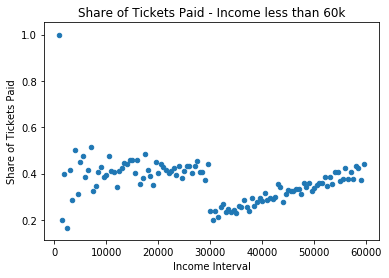

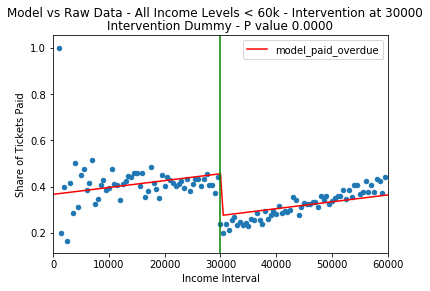

Limit data to .75 to 1.25 of the intervention point of 60000


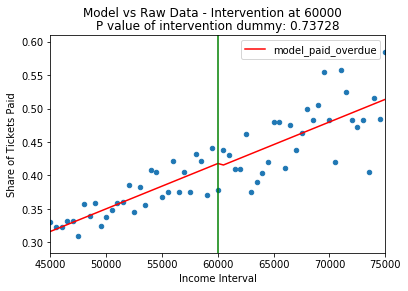


Response to question 6:  
The policy does have an impact on the resident's likelihood to pay on time.  However,
there is one concern - I am not sure if this is due to the data or incorrect
analysis.  I see that the residents in the $20,000-$30,000 income levels are more 
likely to pay the tickets than the residents in the $30,000-$40,000 income levels.  
If one looks at all the data, it is clear that there is a gap at $30,000 income level.
The drivers with incomes below $30,000 seem to have a similar propensity to pay on time, and their
likelihood to pay on time is generally higher than folks with an income from $30,000 to $50,000.
However, as the income increases above $30,000 the likelihood to pay on time increase.
The policy needs to investigate this further.

Response to question 7:
I would recommend that the policy be expanded to incomes less than $60,000.  
The data shows that as incomes decrease between $60,000 and $30,000, the likelihood
to pay on time decrease, and if a polic

In [10]:
# look at data for folks with income less than 60k.
# only consider tickets that have been paid or are overdue
ci_df = court_income[(court_income['ticket_status']=='paid') | (court_income['ticket_status']=='overdue')]
    
# create a 0/1 variable for ticket status.
ci_df['ticket_status_01'] =  np.where(ci_df['ticket_status']=='paid',1,0)
    
ci_df = ci_df[ (ci_df['income']<=60000)]

# find the min max of incomes.
min_i = ci_df['income'].min()
max_i = ci_df['income'].max()

# create a series with an increment of 500.
incre_ment_60 = 500.
ser_grp_60 = round(max_i/incre_ment_60,0)+1 

# create a data frame for the rdd model
# start with empty df.
# add the avg. amount paid for each increment.
rdd_60k = pd.DataFrame(columns=['interval','paid_overdue'])
for x60 in xrange(0, int(incre_ment_60*ser_grp_60), int(incre_ment_60)):
    temp =  { 'interval': x60, 
              'paid_overdue': ci_df[ (ci_df['income']>=x60) & (ci_df['income'] < (x60 + incre_ment_60)) ]['ticket_status_01'].mean() }
    rdd_60k = rdd_60k.append(temp,ignore_index=True)


# Do a plot of the income and avg fine.
rdd_60k.plot(x='interval',y='paid_overdue',kind='scatter')
plt.title('Share of Tickets Paid - Income less than 60k')
plt.xlabel('Income Interval')
plt.ylabel('Share of Tickets Paid')
plt.show()




# create a dummy variable that indicates the intervention line.
intervention = 30000
rdd_60k['intervention_dummy'] = np.where(rdd_60k['interval']<=intervention,1,0)

# run a regression model.
reg_model = smf.ols('paid_overdue ~ intervention_dummy + interval', data=rdd_60k).fit()
# print reg_model.summary()

# plot the model against the raw data.
ax = rdd_60k.plot(x='interval',y='paid_overdue',kind='scatter')
p = reg_model.params
rdd_60k['model_paid_overdue'] = p.Intercept + p.intervention_dummy * rdd_60k['intervention_dummy'] + p.interval * rdd_60k['interval']

p_60k = reg_model.pvalues['intervention_dummy']

rdd_60k.plot(kind='line',x='interval',y='model_paid_overdue', ax=ax, color='r')
plt.axvline(x=intervention, color='g')
plt.suptitle('Model vs Raw Data - All Income Levels < 60k - Intervention at %d'%intervention)
plt.title('Intervention Dummy - P value %.4f'%p_60k)
plt.xlabel('Income Interval')
plt.ylabel('Share of Tickets Paid')
plt.show()
plt.close()




# analyze the situation at 60k.
p_60 = intervention_paid_overdue(court_income, 60000)
# print 'P value of intervention dummy at 60000: %.4f'%p_60 

print '''\nResponse to question 6:  
The policy does have an impact on the resident's likelihood to pay on time.  However,
there is one concern - I am not sure if this is due to the data or incorrect
analysis.  I see that the residents in the $20,000-$30,000 income levels are more 
likely to pay the tickets than the residents in the $30,000-$40,000 income levels.  
If one looks at all the data, it is clear that there is a gap at $30,000 income level.
The drivers with incomes below $30,000 seem to have a similar propensity to pay on time, and their
likelihood to pay on time is generally higher than folks with an income from $30,000 to $50,000.
However, as the income increases above $30,000 the likelihood to pay on time increase.
The policy needs to investigate this further.
'''

print '''Response to question 7:
I would recommend that the policy be expanded to incomes less than $60,000.  
The data shows that as incomes decrease between $60,000 and $30,000, the likelihood
to pay on time decrease, and if a policy were to reduce the burden of payment 
then it will likely to have a desirable impact on the residents' likelihood to pay on time.
'''

# Section 3: Predictive Modeling (binary classification)

**Task A**: load the data that includes neighborhood characteristics

As a note, this data adds information on the characteristics of the driver's census tract (GEOID), and restricts the sample to those with income $\geq$ 30,000, with data on driver attributes, and with either a late payment or an on-time payment


In [11]:
# load the data.
# stops_for_model = pd.read_csv(r'https://surveygizmolibrary.s3.amazonaws.com/library/495376/stops_forpredmodel.csv')
stops_pred_model = pd.read_csv(r'C:\Temp\dclab\stops_forpredmodel.csv')

# get basic info

print stops_pred_model.info()
print stops_pred_model.shape

print stops_pred_model.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18284 entries, 0 to 18283
Data columns (total 16 columns):
GEOID                                                      18284 non-null int64
stop_id                                                    18284 non-null int64
income                                                     18284 non-null int64
ticket_amount                                              18284 non-null int64
officer_id                                                 18284 non-null object
stop_date                                                  18284 non-null object
driver_age                                                 18284 non-null int64
driver_sex                                                 18284 non-null object
censustract_Bachelor.s_degree_or_higher                    18284 non-null float64
censustract_High_school_graduate_.includes_equivalency.    18284 non-null float64
censustract_Less_than_high_school_graduate                 18284 non-null float64
ce

**Task B**: estimate and evaluate at least three machine learning models to predict the binary label of whether or not a driver made a late payment (latepayment = 1 = yes):

- A tree-based model like random forest or decision tree
- A penalized logistic regression model
- Another ensemble method (e.g., gradient boosting) 
- Any others

The general steps should be:

1. Splitting the data into training and test set

2. Pre-processing the data: When possible, try to mimic the situation you would face with a larger-scale data set (e.g., one with 20 or 30 factor variables), and write code that does the transformations without naming specific variables

3. Estimating in the training set

4. Predicting the label in the test set

5. Evaluating the accuracy of the predictions

*Note*: if the models you choose take too long to estimate while remaining in notebook, feel free to write the modeling code in a separate .py or .R script and import the results back into the notebook. Please attach any of these auxiliary scripts in the attachments below.


In [12]:
# random forest model.

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# pre-specify random state variable
random_st = 12

# save the outcome variable into an array
outcome_var = np.array(stops_pred_model['latepayment'])

# the driver sex is a character varaible. conver to numeric DUMMY var.
stops_pred_model['driver_sex_01'] = np.where(stops_pred_model['driver_sex']=="m",0,1)
stops_pred_model['driver_sex_01'].head()

# get rid of variables that are not ordinal
df_4_model = stops_pred_model.drop(['latepayment','GEOID','stop_id',
                    'officer_id','stop_date','driver_sex'],axis=1)


# save the column names.
model_col_names = list(df_4_model.columns)
# print model_col_names

# convert the model data to an array
model_data_array = np.array(df_4_model)


# create the training and testing data sets.
train_data, test_data, train_outcome, test_outcome = train_test_split(model_data_array, outcome_var, test_size = 0.25, 
                     random_state = random_st)



print '\nRandom forest model.'
rf = RandomForestRegressor(n_estimators = 1000, random_state = random_st)

# fit the model.
rf.fit(train_data, train_outcome)

# use the model to predict the test data set
predictions = rf.predict(test_data)

# assign the predicted values to a 0/1 group
predic_group = np.where(predictions<=0.5,0,1)

# calculate the "correct" predictions
correct_pred = np.where(predic_group == test_outcome, 1, 0)

# summarize the results.
print '\nFeature importances'
f_i = rf.feature_importances_

for i in xrange(0,len(model_col_names)): 
    print '%-20.20s %.4f'%(model_col_names[i], f_i[i])

print '\nRandom Forest Model - Predicted correctly: %.1f%%'%(sum(correct_pred)*100./len(correct_pred))
print '.....'



print '\nLogistic Regression with penalty'

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='liblinear', multi_class='auto', 
              random_state=random_st, penalty='l1').fit(train_data, train_outcome)

log_reg_test_res = log_reg.predict(test_data)
correct_pred = np.where(log_reg_test_res == test_outcome, 1, 0)

print '\nEstimated Coefficients: '

xyz = log_reg.coef_

for i in xrange(0,len(model_col_names)): 
    print '%-20.20s %+.4e'%(model_col_names[i], xyz[0][i])
    
print '\nLogistic Regression Model - Predicted correctly: %.1f%%'%(sum(correct_pred)*100./len(correct_pred))
print '.....'


print '\nSimple Logit model. -- different library'
print '   should give similar results as the logistic regression'
from statsmodels.formula.api import logit

logit= sm.Logit(train_outcome, train_data).fit()

print logit.summary()

test_logit = logit.predict(test_data)
test_logit_01 = np.where(test_logit<=0.5,0,1)
correct_pred = np.where(test_logit_01 == test_outcome, 1, 0)

print '\nLogit Model - Predicted correctly: %.1f%%'%(sum(correct_pred)*100./len(correct_pred))
print '.....'


print '\nProbit model.'
from statsmodels.formula.api import probit

probit= sm.Probit(train_outcome, train_data).fit()

# print logit.summary()

test_probit = probit.predict(test_data)
test_probit_01 = np.where(test_probit<=0.5,0,1)
correct_pred = np.where(test_probit_01 == test_outcome, 1, 0)

print '\nProbit Model - Predicted correctly: %.1f%%'%(sum(correct_pred)*100./len(correct_pred))
print '.....'



print '\nGradient boosting method'
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=1)
gbc.fit(train_data, train_outcome)
gbc_predict = gbc.predict(test_data)

print 'Gradient boosting method predicted correctly: %.1f%%'%(100*gbc.score(test_data, test_outcome))
print '.....'




Random forest model.

Feature importances
income               0.2698
ticket_amount        0.1078
driver_age           0.3282
censustract_Bachelor 0.0310
censustract_High_sch 0.0393
censustract_Less_tha 0.0407
censustract_median_h 0.0683
censustract_Owner_oc 0.0258
censustract_Renter_o 0.0258
censustract_Some_col 0.0395
driver_sex_01        0.0238

Random Forest Model - Predicted correctly: 74.1%
.....

Logistic Regression with penalty

Estimated Coefficients: 
income               -1.3804e-05
ticket_amount        +8.2137e-04
driver_age           -6.0932e-02
censustract_Bachelor -3.1397e-03
censustract_High_sch +0.0000e+00
censustract_Less_tha +7.8907e-01
censustract_median_h -6.0431e-06
censustract_Owner_oc +1.8020e+00
censustract_Renter_o +1.7131e+00
censustract_Some_col +5.3811e-01
driver_sex_01        -3.5652e-02

Logistic Regression Model - Predicted correctly: 75.5%
.....

Simple Logit model. -- different library
   should give similar results as the logistic regression
Optimiza

**Task C (optional bonus)**: a colleague is interested in how well the model performs among the top 10\% of high-risk drivers-- that is, the drivers with a predicted probability of late payment in the highest 10\% among the test set.

This is because, due to limited resources, the colleague wants to make sure the model is performing well for those the fine reduction policy might target.

Calculate the precision in the top 10\% of high-risk drivers for each of the models. Create a table or plot (just show in the code), and briefly interpret what this shows about the model's accuracy.

In [13]:
# pick the random forest model, and calculate the model results.


# create a data frame with predictions and actual results.
all_df = pd.DataFrame({'actual':test_outcome, 'RF prediction':predictions,
                     'Logistic Regression':  log_reg_test_res,
                     'Logit Model': test_logit,
                     'Probit Model': test_probit,
                     'GB Model': gbc_predict})


# select the top 10% of high risk drivers - using the Random Forest model results.
all_df['pred_rank'] = all_df["RF prediction"].rank() 
#print '\nPrediction rank - all test cases\n', all_df.head()

top10p = all_df[all_df['pred_rank']>0.9*len(all_df)]
#print '\nPrediction rank - top 10% high risk drivers - RF model\n',top10p.head()


# calculate how well these high risk folks do.
# assign the predicted values to a 0/1 group
top10p['RF Result 01'] = np.where(top10p['RF prediction']<=0.5,0,1)
top10p['Logit Result 01'] = np.where(top10p['Logit Model']<=0.5,0,1)
top10p['Probit Result 01'] = np.where(top10p['Probit Model']<=0.5,0,1)


print top10p.head()

rf_correct_pred = np.sum( np.where(top10p['RF Result 01']==top10p['actual'],1,0) )
logit_correct_pred = np.sum( np.where(top10p['Logit Result 01']==top10p['actual'],1,0) )
probit_correct_pred = np.sum( np.where(top10p['Probit Result 01']==top10p['actual'],1,0) )
gb_correct_pred = np.sum( np.where(top10p['GB Model']==top10p['actual'],1,0) )
logreg_correct_pred = np.sum( np.where(top10p['Logistic Regression']==top10p['actual'],1,0) )

print '\nResults for top 10% high risk drivers - as indicated by Random Forest Model.'
print '\nRandom Forest Model - High Risk Drivers - Predicted correctly: %.1f%%'%(100.*rf_correct_pred / len(top10p))
print '\nLogistic Regression Model - High Risk Drivers - Predicted correctly: %.1f%%'%(100.*logreg_correct_pred / len(top10p))
print '\nGB Model - High Risk Drivers - Predicted correctly: %.1f%%'%(100.*gb_correct_pred / len(top10p))
print '\nLogit Model - High Risk Drivers - Predicted correctly: %.1f%%'%(100.*logit_correct_pred / len(top10p))
print '\nProbit Forest Model - High Risk Drivers - Predicted correctly: %.1f%%'%(100.*probit_correct_pred / len(top10p))
print '.....'
print '''\nThe model prediction results for high risk drivers are similar to the overall results. 
I would have a high confidence in the model's ability to predict.'''





    GB Model  Logistic Regression  Logit Model  Probit Model  RF prediction  \
18         1                    1     0.732697      0.729179          0.913   
19         1                    1     0.723698      0.720722          0.915   
21         1                    1     0.832256      0.830567          0.888   
22         1                    1     0.865684      0.866150          0.913   
27         1                    0     0.486997      0.484302          0.890   

    actual  pred_rank  RF Result 01  Logit Result 01  Probit Result 01  
18       1     4335.0             1                1                 1  
19       0     4347.5             1                1                 1  
21       0     4158.5             1                1                 1  
22       1     4335.0             1                1                 1  
27       0     4172.5             1                0                 0  

Results for top 10% high risk drivers - as indicated by Random Forest Model.

Random F

8\. **Question**: compare the feature importances from the tree-based model to the coefficients from the penalized logistic regression.

In 2-3 sentences:

1. Pretend you are explaining the differences between feature importances and coefficients to a social science colleague. Address questions like why all the feature importances are all positive and why some of the coefficients are zero in the penalized logistic regression model.


2. Does your model highlight factors that predict late payment *within* drivers with incomes over \\$30,000? Explain whether any of the factors suggest ways to decide who should be eligible for fine reduction

In [14]:
print '''8.1.  The feature importances add up to 1.  They are all positive, and 
reflect the relative importance of the variables in terms of explaining the variability of data.  
So a variable with feature importance of 0.2 is twice as important as a variable with
feature importance of 0.1.    

The coefficients of the logistic regression are not the same of feature importance.  The coefficients
can be either positive or negative and sign signifies the "directionality" of the variable - i.e., a variable
with a positive sign will have positive correlation with the independent variable.  A coefficient could be
zero (or close to zero) for a variety of reasons.  The coefficient could be very small if the variable that it is
associated with has very high value relative to other variables.  For example, in the data set income is
measured in $s and has values ranging from a few thousand to over $150,000.  While there are other 
variables that are in the 0-1 range.  Thus, we could see some variable with close to zero values.

8.2 The model does not have any specific variable to split the drivers with income above/below $30,000.
However, there is an income variable, that is significant and has a negative sign indicating that 
as the income increases the likelihood of late payments decrease.  Thus, any program that helps
drivers with income below $30,000 should have a positive effect on the likelihood to pay the fine.

'''



8.1.  The feature importances add up to 1.  They are all positive, and 
reflect the relative importance of the variables in terms of explaining the variability of data.  
So a variable with feature importance of 0.2 is twice as important as a variable with
feature importance of 0.1.    

The coefficients of the logistic regression are not the same of feature importance.  The coefficients
can be either positive or negative and sign signifies the "directionality" of the variable - i.e., a variable
with a positive sign will have positive correlation with the independent variable.  A coefficient could be
zero (or close to zero) for a variety of reasons.  The coefficient could be very small if the variable that it is
associated with has very high value relative to other variables.  For example, in the data set income is
measured in $s and has values ranging from a few thousand to over $150,000.  While there are other 
variables that are in the 0-1 range.  Thus, we could see some variable wi

# Section 4. Project Scoping

Please complete this on the main questionnaire. 

In [15]:
print 'Please see the responses on the submission website.'

Please see the responses on the submission website.
